In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from task_decomposition.analysis.comparisons import subtask_similarity, extract_subtask_from_gpt_output_file, extract_subtask_from_groundtruth_file, semantic_distance, extract_subtask_from_video_llava_file
from task_decomposition.paths import DATA_GT_TXT_PATH, GPT_OUTPUT_PATH, VIDEO_LLAVA_PATH



def format_string(s: list) -> str:
    """
    Add a newline after every 3 words in the list
    """
    x = s.split(" ")
    s_format = []
    for i in range(len(x)):
        s_format.append(x[i])
        s_format.append("\n") if i % 3 == 0 else None
    return " ".join(s_format)


# Redefine the add_intervals_with_colors function to position the text at the edges
def add_intervals_with_colors(intervals, row, color_map, ax, angle):
    for idx, (start, end, description) in enumerate(intervals):
        color = color_map[idx]
        rect_width = end - start if end - start > 0 else 1
        rect = mpatches.Rectangle(
            (start, row), rect_width, 0.8, edgecolor="black", facecolor=color
        )
        ax.add_patch(rect)

        # Position the text at the top and bottom edges of the bars
        if row == 1:  # For the top bar, start the text at the top edge
            text_y = row + 0.8
            va = "bottom"
        else:  # For the bottom bar, start the text at the bottom edge
            text_y = row
            va = "top"

        # Place the text at a 45 degree angle for actual and -45 for predicted
        ax.text(
            (start+end) / 2,
            text_y,
            format_string(description),
            ha="left",
            va=va,
            fontsize="large",
            color="black",
            rotation=angle,
            rotation_mode="anchor",
        )

def box_plots(actual, predicted, title, ax=None):
    color_map = ['green', 'blue', 'purple', 'orange', 'red', 'yellow', 'pink', 'brown', 'grey', 'cyan']

    # preprocess so that each subtask in predicted matches the maximum semantic score in actual
    predicted_color_map = []
    # for p in predicted:
    #     max_score = -1
    #     max_idx = 0
    #     for idx, a in enumerate(actual):
    #         score = semantic_distance(a[2], p[2])
    #         if score >= max_score:
    #             max_score = score
    #             max_idx = idx
    #     predicted_color_map.append(color_map[max_idx])

    # Add actual intervals with color map and angle the text at 45 degrees
    add_intervals_with_colors(actual, 1, color_map, ax, angle=45)

    # Add predicted intervals with color map and angle the text at -45 degrees
    add_intervals_with_colors(predicted, 0, color_map, ax, angle=-45)

    # Set the limits, labels, and title
    ax.set_xlim(-5, max(actual[-1][1], predicted[-1][1])+5)
    ax.set_ylim(-9, 14)
    ax.set_yticks([0.4, 1.4])
    ax.set_yticklabels(["Predicted", "Ground Truth"], fontsize=12)
    ax.set_xlabel("Step Number")
    ax.set_title(title, fontsize=14)

    plt.tight_layout()
    plt.show()

/opt/anaconda3/envs/suite/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Visualizing the subtasks from /Users/jonathansalfity/Documents/dev/task_decomposition/task_decomposition/data/txt/groundtruths/Stack_20240220-131037_34_gt.txt and /Users/jonathansalfity/Documents/dev/task_decomposition/task_decomposition/data/gpt_outputs/textvideo/Stack/Stack_20240220-131037_34.json


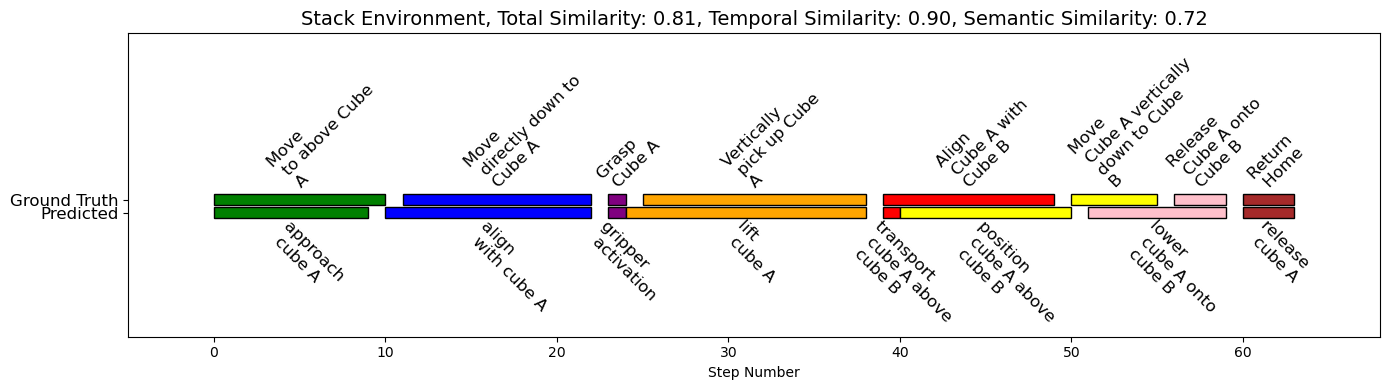

[(0, 10, 'Move to above Cube A'), (11, 22, 'Move directly down to Cube A'), (23, 24, 'Grasp Cube A'), (25, 38, 'Vertically pick up Cube A'), (39, 49, 'Align Cube A with Cube B'), (50, 55, 'Move Cube A vertically down to Cube B'), (56, 59, 'Release Cube A onto Cube B'), (60, 63, 'Return Home')]
[(0, 9, 'approach cube A'), (10, 22, 'align with cube A'), (23, 23, 'gripper activation'), (24, 38, 'lift cube A'), (39, 39, 'transport cube A above cube B'), (40, 50, 'position cube A above cube B'), (51, 59, 'lower cube A onto cube B'), (60, 63, 'release cube A')]


In [94]:
## visualize trajectory decompositions
env_name = "Stack"
query_type = "textvideo"
# min
gt_file = DATA_GT_TXT_PATH+"/"+"Stack_20240220-130911_22_gt.txt"
gpt_file = GPT_OUTPUT_PATH+f"/{query_type}/{env_name}/Stack_20240220-130911_22.json" 

# max 
gt_file = DATA_GT_TXT_PATH+"/"+"Stack_20240220-131037_34_gt.txt"
gpt_file = GPT_OUTPUT_PATH+f"/{query_type}/{env_name}/Stack_20240220-131037_34.json" 

gt_subtasks = extract_subtask_from_groundtruth_file(gt_file)
gpt_subtasks = extract_subtask_from_gpt_output_file(gpt_file)
similarity = subtask_similarity(gt_subtasks, gpt_subtasks)
print(f"Visualizing the subtasks from {gt_file} and {gpt_file}")
# create new figure
fig, ax = plt.subplots(figsize=(14, 4))
title = f"{env_name} Environment, Total Similarity: {similarity['total']:.2f}, Temporal Similarity: {similarity['temporal']:.2f}, Semantic Similarity: {similarity['semantic']:.2f}"
box_plots(gt_subtasks, gpt_subtasks, title, ax=ax)

print(gt_subtasks)
print(gpt_subtasks)

In [16]:
def compute_batch_similarity(env_name: str, 
                             query_type: str, 
                             SAVE_OUTPUT: bool = True):
    """
    Compute the similarity between groundtruth and gpt output files for a given environment.
    """
    GPT_FILEPATH = GPT_OUTPUT_PATH+f"/{query_type}/{env_name}" 
    gt_files = [f for f in os.listdir(DATA_GT_TXT_PATH) if env_name in f]
    gt_files = sorted(gt_files)
    gpt_files = [f for f in os.listdir(GPT_FILEPATH) if env_name in f]
    gpt_files = sorted(gpt_files)

    assert len(gt_files) == len(gpt_files), f"The number of groundtruth files {len(gt_files)} and gpt output files {len(gpt_files)} are not the same."

    n_runs = len(gt_files)
    output = {"temporal":np.full(n_runs, np.nan), 
            "semantic":np.full(n_runs, np.nan), 
            "total":np.full(n_runs, np.nan)
            }

    for idx, (gt_file, gpt_file) in enumerate(zip(gt_files, gpt_files)):
        # make sure we are comparing the same run
        gt_run = gt_file.split("_gt")[0]
        gpt_run = gpt_file.split(".")[0]
        assert gt_run==gpt_run, f"The groundtruth file {gt_file} and gpt output file {gpt_file} are not from the same run."

        # extract subtasks from groundtruth and gpt output files
        gt_subtasks = extract_subtask_from_groundtruth_file(DATA_GT_TXT_PATH+"/"+gt_file)
        gpt_subtasks = extract_subtask_from_gpt_output_file(GPT_FILEPATH+"/"+gpt_file)

        # compare the subtasks
        similarity = subtask_similarity(gt_subtasks, gpt_subtasks)
        output['temporal'][idx]=similarity["temporal"]
        output['semantic'][idx]=similarity["semantic"]
        output['total'][idx]=similarity["total"]
        print(f"Similarity between {gt_file} and {gpt_file} is {similarity['total']:.2f}")

    if SAVE_OUTPUT:
        np.savez(f"{GPT_FILEPATH}_results.npz", **output)

    print(f"Average Similarity: {np.mean(output['total']):.2f}, Average Temporal Similarity: {np.mean(output['temporal']):.2f}, Average Semantic Similarity: {np.mean(output['semantic']):.2f}")


env_names = ["Lift", "Door", "Stack"]#PickPlace", "Stack"]
query_type = "textvideo"
for env_name in env_names:
    compute_batch_similarity(env_name, query_type, SAVE_OUTPUT=False)


Similarity between Stack_20240220-130620_0_gt.txt and Stack_20240220-130620_0.json is 0.84
Similarity between Stack_20240220-130630_1_gt.txt and Stack_20240220-130630_1.json is 0.76
Similarity between Stack_20240220-130638_2_gt.txt and Stack_20240220-130638_2.json is 0.80
Similarity between Stack_20240220-130646_3_gt.txt and Stack_20240220-130646_3.json is 0.77
Similarity between Stack_20240220-130653_4_gt.txt and Stack_20240220-130653_4.json is 0.74
Similarity between Stack_20240220-130701_5_gt.txt and Stack_20240220-130701_5.json is 0.83
Similarity between Stack_20240220-130710_6_gt.txt and Stack_20240220-130710_6.json is 0.83
Similarity between Stack_20240220-130718_7_gt.txt and Stack_20240220-130718_7.json is 0.80
Similarity between Stack_20240220-130726_8_gt.txt and Stack_20240220-130726_8.json is 0.78
Similarity between Stack_20240220-130734_9_gt.txt and Stack_20240220-130734_9.json is 0.71
Similarity between Stack_20240220-130741_10_gt.txt and Stack_20240220-130741_10.json is 0.

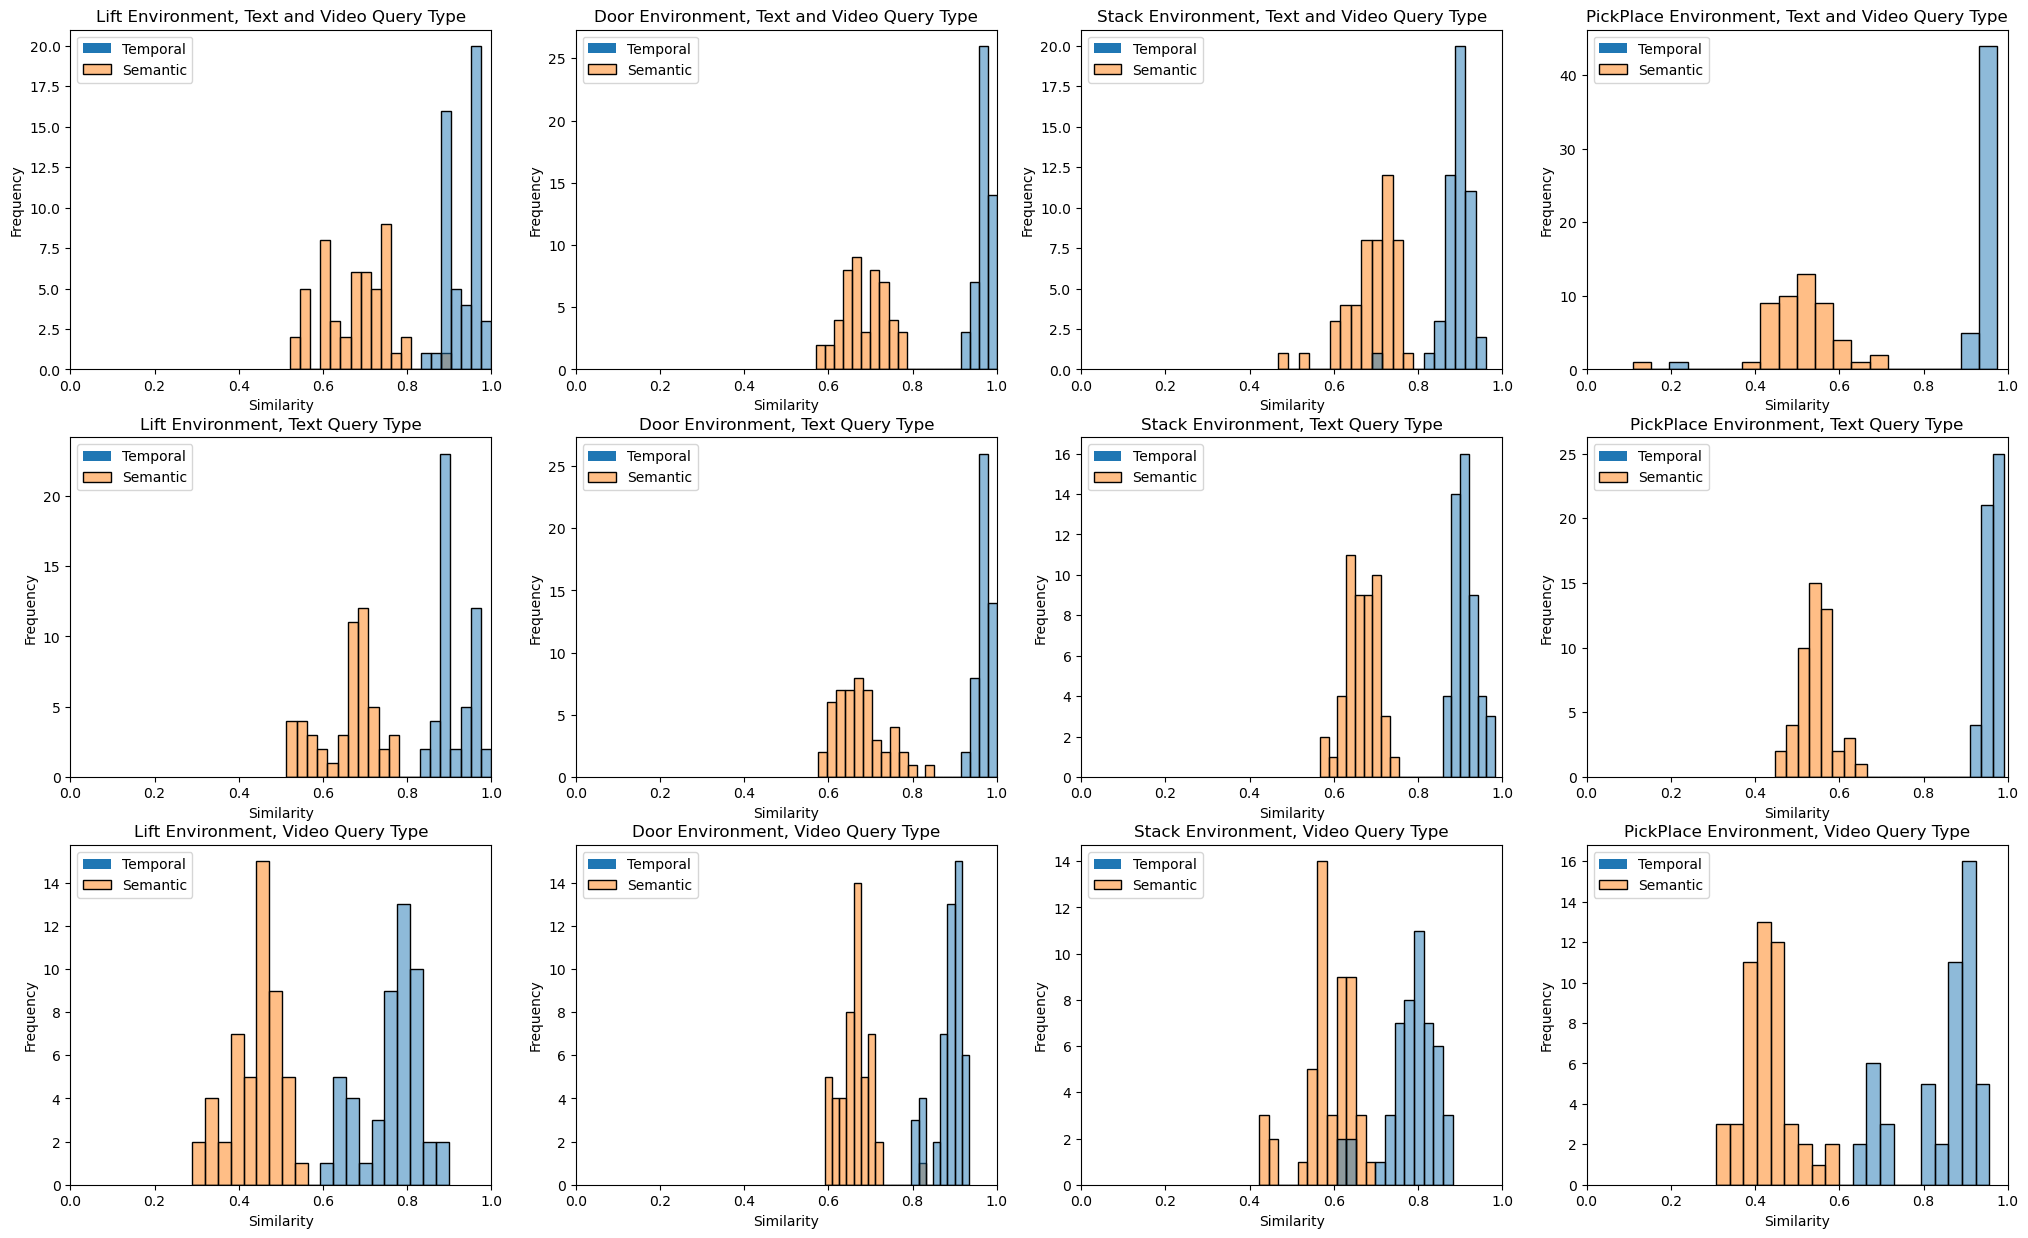

In [93]:
# sns.histplot(data=[temporal, semantic, total], legend=True, kde=True, bins=25)
# env_name = "Door"
# query_type = "video"
# npresultspath = GPT_OUTPUT_PATH+f"/{query_type}/{env_name}" 
# similarity = np.load(f"{npresultspath}_results.npz", allow_pickle=True)
N_BINS = 20
def make_histogram_grid(env_names: list, query_types: list, similarity: dict):
    """
    Create a grid of histograms for the similarity scores between groundtruth and gpt output files.
    Each histogram will show the distribution of the similarity scores for a given environment and query type.
    """
    n_rows = len(query_types)
    n_cols = len(env_names)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(25, 5*n_rows))
    for i, env_name in enumerate(env_names):
        for j, query_type in enumerate(query_types):
            npresultspath = GPT_OUTPUT_PATH+f"/{query_type}/{env_name}" 
            similarity = np.load(f"{npresultspath}_results.npz", allow_pickle=True)
            temporal = similarity['temporal']
            semantic = similarity['semantic']
            ax = axs[j,i]
            sns.histplot(data=[temporal, semantic], legend=True, bins=N_BINS, ax=ax)
            ax.legend(["Temporal", "Semantic"], loc='upper left')
            ax.set_xlabel('Similarity')
            ax.set_ylabel('Frequency')
            ax.set_xlim(0, 1)
            query_type = "Text and Video" if query_type=="textvideo" else query_type.capitalize()
            ax.set_title(f"{env_name} Environment, {query_type} Query Type")

envs = ["Lift", "Door", "Stack", "PickPlace"]
query_types = ["textvideo", "text", "video"]
make_histogram_grid(envs, query_types, similarity)


In [95]:
# Make the big table of all the similarity results
query_types = ["textvideo", "text" , "video"]
env_names = ["Lift", "Door", "Stack", "PickPlace"]
for query_type in query_types:
    print(f"{query_type}: ")
    for env_name in env_names:
        npresultspath = GPT_OUTPUT_PATH+f"/{query_type}/{env_name}" 
        similarity = np.load(f"{npresultspath}_results.npz", allow_pickle=True)
        total_mean, total_std = np.mean(similarity['total']), np.std(similarity['total'])
        print(f" {env_name}", end="")
        temporal_mean, temporal_std = np.mean(similarity['temporal']), np.std(similarity['temporal'])
        semantic_mean, semantic_std = np.mean(similarity['semantic']), np.std(similarity['semantic'])
        print(f"\t\tTemporal: {temporal_mean:.2f} +/- {temporal_std:.2f}, Semantic: {semantic_mean:.2f} +/- {semantic_std:.2f}, Total: {total_mean:.2f} +/- {total_std:.2f}")
    print("______________________________________________________________________")

textvideo: 
 Lift		Temporal: 0.93 +/- 0.04, Semantic: 0.68 +/- 0.08, Total: 0.80 +/- 0.05
 Door		Temporal: 0.97 +/- 0.02, Semantic: 0.68 +/- 0.05, Total: 0.83 +/- 0.03
 Stack		Temporal: 0.89 +/- 0.04, Semantic: 0.69 +/- 0.06, Total: 0.79 +/- 0.05
 PickPlace		Temporal: 0.94 +/- 0.11, Semantic: 0.51 +/- 0.09, Total: 0.72 +/- 0.09
______________________________________________________________________
text: 
 Lift		Temporal: 0.92 +/- 0.04, Semantic: 0.66 +/- 0.07, Total: 0.79 +/- 0.05
 Door		Temporal: 0.97 +/- 0.02, Semantic: 0.68 +/- 0.06, Total: 0.82 +/- 0.03
 Stack		Temporal: 0.91 +/- 0.03, Semantic: 0.67 +/- 0.04, Total: 0.79 +/- 0.03
 PickPlace		Temporal: 0.96 +/- 0.02, Semantic: 0.55 +/- 0.04, Total: 0.75 +/- 0.02
______________________________________________________________________
video: 
 Lift		Temporal: 0.76 +/- 0.07, Semantic: 0.44 +/- 0.06, Total: 0.60 +/- 0.06
 Door		Temporal: 0.89 +/- 0.03, Semantic: 0.66 +/- 0.04, Total: 0.77 +/- 0.03
 Stack		Temporal: 0.79 +/- 0.06, Semant

In [146]:
env_name = "Door"
query_type = "video"
npresultspath = GPT_OUTPUT_PATH+f"/{query_type}/{env_name}"
similarity = np.load(f"{npresultspath}_similarity_results.npy", allow_pickle=True)